In [145]:
import numpy as np
from data_loader import load_dataset, load_challenge, save_challenge
from torch import nn
import torch
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import StandardScaler
from eval_script import compute_revenue
import matplotlib.pyplot as plt
import scipy

In [146]:
class BirdCrossEntropyLoss(nn.Module):
    def __init__(self, device):
        super(BirdCrossEntropyLoss, self).__init__()
        self.rev_matrix = torch.tensor(np.array(
            [[0.05, -0.2, -0.2, -0.2, -0.2, -0.2, -0.2],
             [-0.25,  1., -0.3, -0.1, -0.1, -0.1, -0.1],
                [-0.02, -0.1,  1., -0.1, -0.1, -0.1, -0.1],
                [-0.25, -0.1, -0.3,  1., -0.1, -0.1, -0.1],
                [-0.25, -0.1, -0.3, -0.1,  1., -0.1, -0.1],
                [-0.25, -0.1, -0.3, -0.1, -0.1,  1., -0.1],
                [-0.25, -0.1, -0.3, -0.1, -0.1, -0.1,  1.]])).to(device)
        self.cet = nn.CrossEntropyLoss(reduction='none').to(device)
        self.device = device

    def forward(self, input, target, ignored): #include agreement somehow?? (results are not promising)

        ce_loss = self.cet(input, target)

        input_labels = torch.argmax(input, dim=1)
        target_labels = torch.argmax(target, dim=1)
        wanted = self.rev_matrix[target_labels, target_labels]
        actual = self.rev_matrix[target_labels, input_labels]
        cost = wanted - actual
        custom_loss = (1 + cost) * ce_loss * (~ignored)

        return custom_loss.mean()


In [147]:
class BirdDataset(Dataset):
    def __init__(self, birdset, is_train, device, left_offset, right_offset, scaler=None):
        self.device = device
        self.left_offset = left_offset
        self.right_offset = right_offset
        self.data = []
        self.labels = []
        self.ignored = []
        self.counts = []
        self.is_train = is_train

        for bird in birdset:
            if is_train:
                self.data.extend(birdset[bird]['train_features'])
                self.labels.extend(birdset[bird]['train_labels'])
                for call in birdset[bird]['train_labels']:
                    self.counts.append(len(call))
                    expanded = scipy.ndimage.maximum_filter1d(call, 3)
                    ignore = (expanded != call) & (call == 0)
                    self.ignored.append(ignore)
            else:
                self.data.extend(birdset[bird]['test_features'])
                self.labels.extend(birdset[bird]['test_labels'])
                for call in birdset[bird]['test_labels']:
                    self.counts.append(len(call))
                    expanded = scipy.ndimage.maximum_filter1d(call, 3)
                    ignore = (expanded != call) & (call == 0)
                    self.ignored.append(ignore)

        if scaler == None:
            scaler = StandardScaler()
            scaler.fit(np.concatenate(self.data))
        self.scaler = scaler

        self.length = np.sum(self.counts)
        self.counts = np.cumsum(self.counts)

        self.data.insert(0, np.zeros((left_offset, 548)))
        self.labels.insert(0, np.zeros((left_offset), dtype=int))
        self.ignored.insert(0, np.ones((left_offset), dtype=int))

        self.data.append(np.zeros((right_offset, 548)))
        self.labels.append(np.zeros((right_offset), dtype=int))
        self.ignored.append(np.ones((right_offset), dtype=int))

        onehot = np.eye(7)
        for i, (call, label, ignored) in enumerate(zip(self.data, self.labels, self.ignored)):
            self.data[i] = torch.tensor(self.scaler.transform(call), dtype=torch.float32).to(self.device)
            self.labels[i] = torch.tensor(onehot[label]).to(self.device)
            self.ignored[i] = torch.tensor(ignored).to(self.device)

    def __len__(self):
        return self.length

    def __getitem__(self, index):
        call_index = np.searchsorted(self.counts, index+1) + 1
        call = self.data[call_index]
        target_index = index - (self.counts[call_index-1] - len(call))
        y = self.labels[call_index][target_index]
        ignored = self.ignored[call_index][target_index]

        #if self.is_train:
        #    cutting_mask = torch.eq(self.labels[call_index], y)
        #    cutting_mask = torch.where(cutting_mask)[0]
        #    cutting_indices = cutting_mask[(target_index - self.left_offset < cutting_mask) & (cutting_mask < target_index - 1)]
        #    left_cut = cutting_indices[torch.randint(0, len(cutting_indices), (1,))] if len(cutting_indices) > 0 else 0
        #    cutting_indices = cutting_mask[(cutting_mask > target_index + 1) & (target_index + self.right_offset > cutting_mask)]
        #    right_cut = cutting_indices[torch.randint(0, len(cutting_indices), (1,))] if len(cutting_indices) > 0 else -1
        #    call = call[left_cut:right_cut]
        #    target_index -= left_cut

        left_call_index = np.random.randint(len(self.data)) if self.is_train else call_index - 1
        left_call = torch.cat((self.data[0], self.data[left_call_index]))
        
        right_call_index = np.random.randint(len(self.data)) if self.is_train else call_index + 1
        right_call = torch.cat((self.data[right_call_index], self.data[-1]))

        data = torch.cat((left_call, call, right_call))
        x = data[len(left_call) + target_index - self.left_offset : len(left_call) + target_index + self.right_offset + 1]

        return x, y, ignored


In [148]:
def train(dataloader, model, loss_fn, optimizer, progress_steps):
    model.train()
    size = len(dataloader.dataset)
    for batch, (X, y, i) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y, i)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if progress_steps != None and batch % progress_steps == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

def test(dataloader, model, loss_fn, show_progress):
    model.eval()
    num_batches = len(dataloader)
    test_loss = 0
    money = 0
    with torch.no_grad():
        for X, y, i in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y, i).item()
            money += compute_revenue(torch.argmax(pred, dim=1).cpu(), torch.argmax(y, dim=1).cpu())

    test_loss /= num_batches
    if show_progress:
        print(f"Avg loss: {test_loss:>8f}, Money saved: {money:.2f}$\n")
    return test_loss, money

def eval(model, train_dataloader, test_dataloader, device, max_epochs, name, lr):
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = BirdCrossEntropyLoss(device)
    lowest_loss = np.infty
    highest_money = -np.infty
    stop_criterion = 0
    for t in range(max_epochs):
        if t % 10 == 0:
            print(f"Epoch {t+1}\n-------------------------------")
        train(train_dataloader, model, loss_fn, optimizer, None)
        loss, money = test(test_dataloader, model, loss_fn, True)
        if money > highest_money:
            highest_money = money
            torch.save(model.state_dict(), f'Models/{name}')
        if loss > lowest_loss:
            stop_criterion += 1
        else:
            lowest_loss = loss
            stop_criterion = 0
        if stop_criterion >= 10:
            break
    model.load_state_dict(torch.load(f'Models/{name}'))
    model.eval()
    print("Done:")
    test(test_dataloader, model, loss_fn, True)


In [151]:
class Bob(nn.Module):
    def __init__(self, left_offset, right_offset):
        super(Bob, self).__init__()

        self.left_offset = left_offset
        self.right_offset = right_offset

        with open(f'../dataset/original/feature_names.txt', 'r') as f:
            self.feature_names = np.array(f.read().splitlines())

        out_size = self.make_image_layers()
        out_size += self.make_one_d_layers()
        self.make_linear_layers(out_size)

    def make_image_layers(self):
        self.melspect_indices = torch.tensor(np.stack(
            (np.where(np.char.startswith(self.feature_names, 'cln_melspect_mean_'))[0],
             np.where(np.char.startswith(self.feature_names, 'cln_melspect_std_'))[0],
             np.where(np.char.startswith(self.feature_names, 'raw_melspect_mean_'))[0],
             np.where(np.char.startswith(self.feature_names, 'raw_melspect_std_'))[0])))
        
        self.contrast_indices = torch.tensor(np.stack(
            (np.where(np.char.startswith(self.feature_names, 'cln_contrast_mean_'))[0],
             np.where(np.char.startswith(self.feature_names, 'cln_contrast_std_'))[0],
             np.where(np.char.startswith(self.feature_names, 'raw_contrast_mean_'))[0],
             np.where(np.char.startswith(self.feature_names, 'raw_contrast_std_'))[0])))
        
        indices = []
        for name in ['mfcc_', 'mfcc_d_', 'mfcc_d2_']:
            for type in ['cln_', 'raw_']:
                indices.append(np.where(np.char.startswith(self.feature_names, f'{type}{name}mean'))[0])
                indices.append(np.where(np.char.startswith(self.feature_names, f'{type}{name}std'))[0])
        self.mfcc_indices = torch.tensor(np.stack(indices))

        self.image_convs = nn.Sequential(
            ConvGroup(20, 32),
            nn.BatchNorm2d(32),
            ConvGroup(32, 64),
            nn.BatchNorm2d(64),
            ConvGroup(64, 64),
            nn.Flatten()
        )
        out_size = self.image_convs(torch.tensor(np.zeros(
            (1, 20, self.left_offset+self.right_offset+1, self.melspect_indices.shape[1]), dtype=np.float32))).shape[1]
        return out_size

    def make_one_d_layers(self):
        indices = [*torch.tensor(np.where(np.char.startswith(self.feature_names, f'yin_'))[0]).split(1)]
        for name in ['zcr_', 'cln_flatness_', 'cln_centroid_', 'cln_flux_', 'cln_energy_', 'cln_power_', 'cln_bandwidth_', 'raw_flatness_', 'raw_centroid_', 'raw_flux_', 'raw_energy_', 'raw_power_', 'raw_bandwidth_']:
            indices.append(np.where(np.char.startswith(self.feature_names, f'{name}mean'))[0])
            indices.append(np.where(np.char.startswith(self.feature_names, f'{name}std'))[0])
        self.one_d_indices = torch.tensor(np.stack(indices))

        self.one_d_convs = nn.Sequential(
            ConvGroup(len(indices), 64, True),
            nn.BatchNorm1d(64),
            ConvGroup(64, 64, True),
            nn.BatchNorm1d(64),
            ConvGroup(64, 64, True),
            nn.Flatten()
        )
        out_size = self.one_d_convs(torch.tensor(np.zeros(
            (1, len(indices), self.left_offset+self.right_offset+1), dtype=np.float32))).shape[1]
        return out_size

    def make_linear_layers(self, conv_out_size):
        self.linear = nn.Sequential(
            nn.Linear(conv_out_size, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Linear(64, 7),
        )

    def forward(self, x):
        convolved = []
        #convolved.append(x[:, :, self.left_offset+1, :].squeeze(1).squeeze(1))
        
        input_images, input_one_d = self.get_images(x)
        conv_image = self.image_convs(input_images)
        convolved.append(conv_image)
        conv_one_d = self.one_d_convs(input_one_d)
        convolved.append(conv_one_d)

        merged = torch.cat(convolved, dim=1)
        result = self.linear(merged)
        return result

    def get_images(self, x):
        input_melspect = x[:, :, self.melspect_indices]
        input_melspect = torch.swapdims(input_melspect, 1, 2).squeeze(2)

        input_contrast = x[:, :, self.contrast_indices]
        input_contrast = torch.swapdims(input_contrast, 1, 2).squeeze(2)
        input_contrast = input_contrast.repeat_interleave(9, dim=3)
        input_contrast = input_contrast[:, :, :, 1:-2]

        input_mfcc = x[:, :, self.mfcc_indices]
        input_mfcc = torch.swapdims(input_mfcc, 1, 2).squeeze(2)
        input_mfcc = input_mfcc.repeat_interleave(3, dim=3)

        input_images = torch.cat((input_melspect, input_contrast, input_mfcc), dim=1)

        input_one_d = x[:, :, self.one_d_indices]
        input_one_d = torch.swapdims(input_one_d, 1, 2).squeeze(3)

        return (input_images, input_one_d)

    def to(self, device):
        self.melspect_indices.to(device)
        self.contrast_indices.to(device)
        self.mfcc_indices.to(device)
        self.one_d_indices.to(device)
        super(Bob, self).to(device)
        return self

class ConvGroup(nn.Module):
    def __init__(self, inf, outf, one_d=False):
        super(ConvGroup, self).__init__()

        if one_d:
            self.process = nn.Conv1d(inf, outf, kernel_size=3, stride=1, padding='same')
            self.scale = nn.MaxPool1d(kernel_size=2, stride=2)
            self.droput = nn.Dropout()
        else:
            self.process = nn.Conv2d(inf, outf, kernel_size=3, stride=1, padding='same')
            self.scale = nn.MaxPool2d(kernel_size=2, stride=2)
            self.droput = nn.Dropout2d()

        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.process(x)
        x = self.scale(x)
        x = self.relu(x)
        x = self.droput(x)
        return x

class Print(nn.Module):
    def __init__(self):
        super(Print, self).__init__()

    def forward(self, x):
        print(x.shape)
        return x

device = 'cuda' if torch.cuda.is_available() else 'cpu'
left_offset = 7
right_offset = 7
name = 'bob'
bob_dummy = Bob(left_offset, right_offset)
model_parameters = filter(lambda p: p.requires_grad, bob_dummy.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print(bob_dummy, params)


Bob(
  (image_convs): Sequential(
    (0): ConvGroup(
      (process): Conv2d(20, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
      (scale): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (droput): Dropout2d(p=0.5, inplace=False)
      (relu): ReLU()
    )
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ConvGroup(
      (process): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
      (scale): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (droput): Dropout2d(p=0.5, inplace=False)
      (relu): ReLU()
    )
    (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ConvGroup(
      (process): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
      (scale): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (droput): Dropout2d(p=0.5, inplace=False)
      (relu): ReL

In [64]:
dataset = load_dataset()

In [152]:
train_set = BirdDataset(dataset, True, device, left_offset, right_offset)
scaler = train_set.scaler
test_set = BirdDataset(dataset, False, device, left_offset, right_offset, scaler)
train_loader = DataLoader(train_set, batch_size=128, shuffle=True)
test_loader = DataLoader(test_set, batch_size=128, shuffle=False)

print(len(train_set), len(test_set))

99236 20146


torch.Size([1, 20, 15, 60]) torch.Size([1, 40, 15])


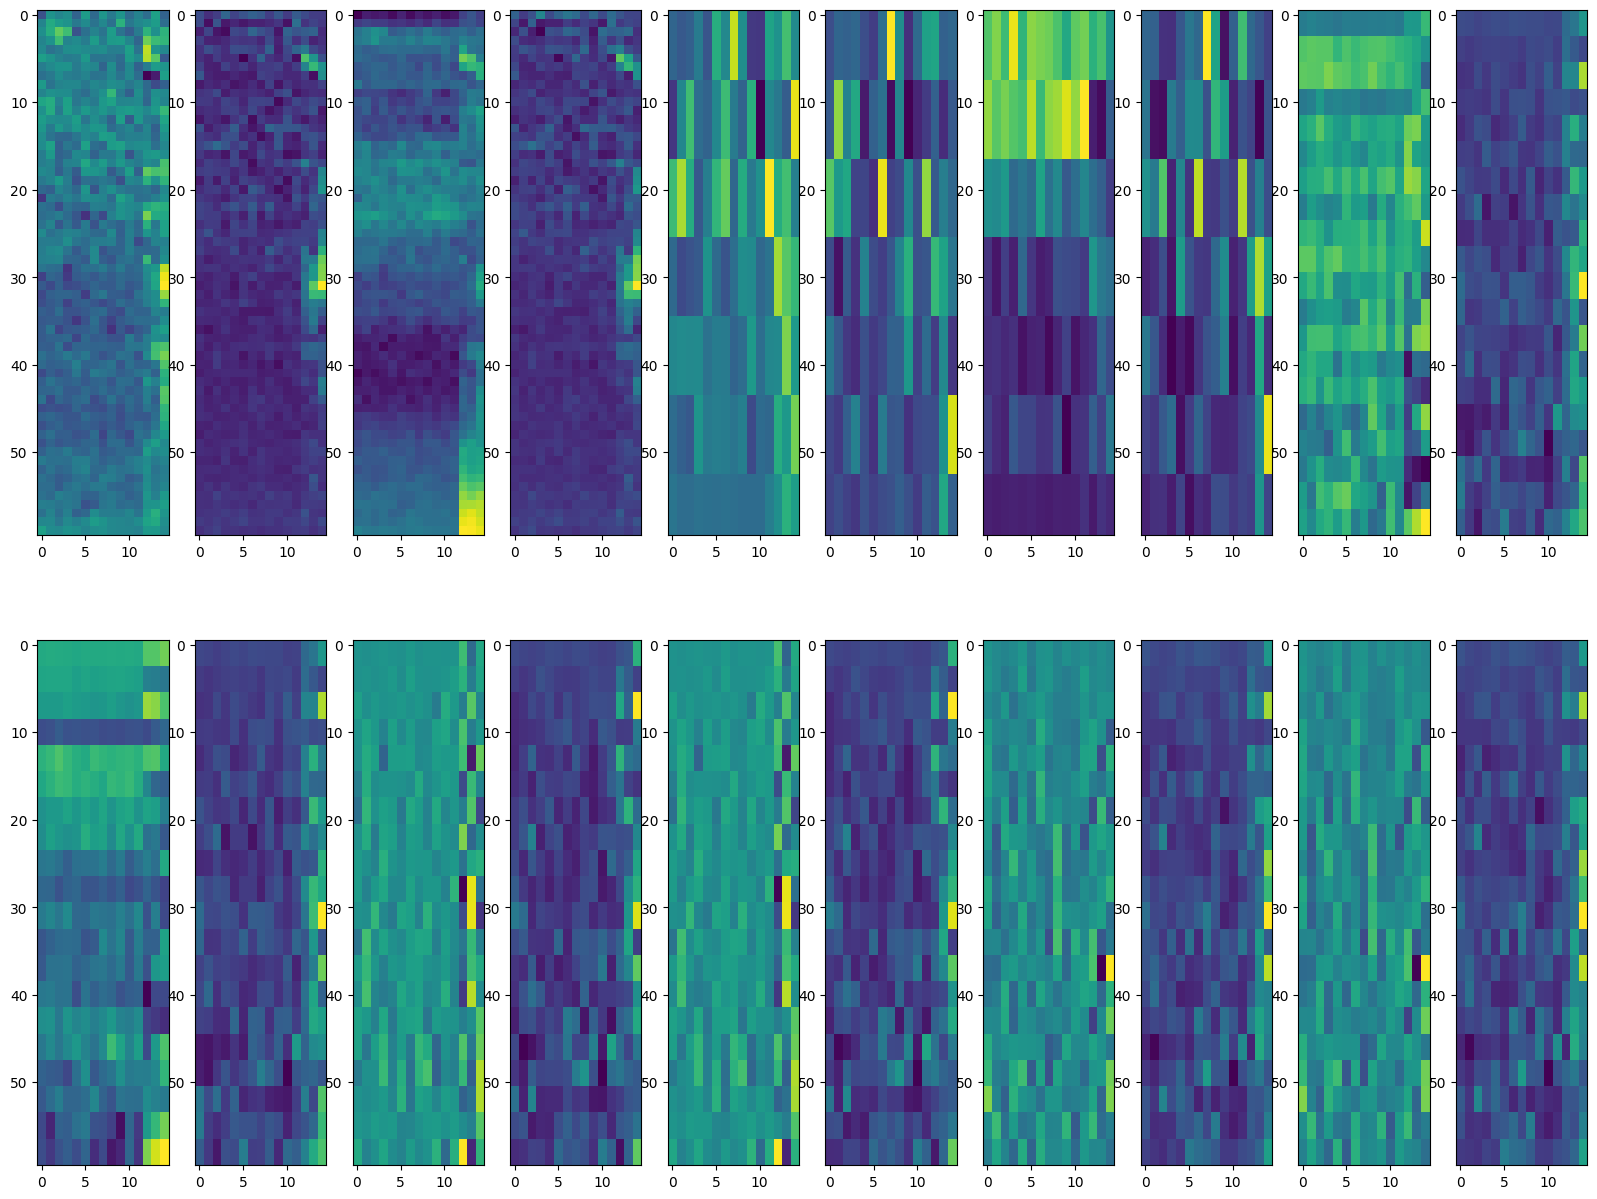

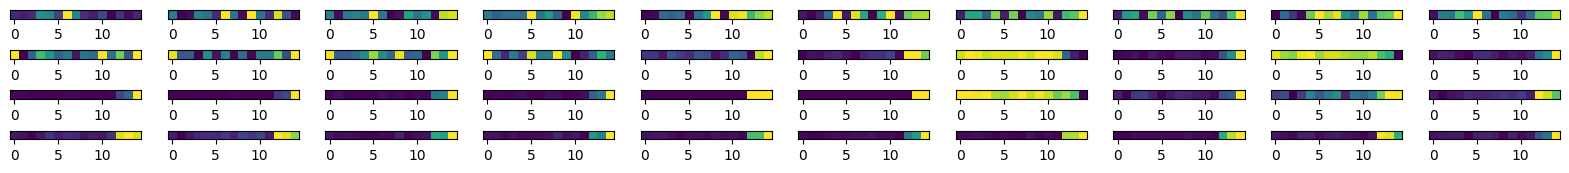

In [153]:
dummy_input = train_set[np.random.randint(0, len(train_set))][0].unsqueeze(0)
images, one_d = bob_dummy.get_images(dummy_input)
print(images.shape, one_d.shape)

fig, axes = plt.subplots(nrows=2, ncols=10, figsize=(20, 15))
for i in range(images.shape[1]):
    axes[i // 10, i % 10].imshow(images[0][i].cpu().swapdims(0, 1), cmap='viridis')

fig2, axes2 = plt.subplots(nrows=4, ncols=10, figsize=(20, 2))
for i in range(one_d.shape[1]):
    axes2[i // 10, i % 10].imshow(one_d[0][i].unsqueeze(1).cpu().swapdims(0, 1), cmap='viridis')
    axes2[i // 10, i % 10].axes.get_yaxis().set_visible(False)


In [154]:
eval(model=Bob(left_offset, right_offset), train_dataloader=train_loader, test_dataloader=test_loader, device=device, max_epochs=500, name=name, lr=0.01)

Epoch 1
-------------------------------
Avg loss: 0.454677, Money saved: 4470.92$

Avg loss: 0.403777, Money saved: 4666.97$

Avg loss: 0.377641, Money saved: 4881.17$

Avg loss: 0.367313, Money saved: 5031.99$

Avg loss: 0.354005, Money saved: 5013.07$

Avg loss: 0.347121, Money saved: 5034.06$

Avg loss: 0.350481, Money saved: 4990.04$

Avg loss: 0.343521, Money saved: 4940.92$

Avg loss: 0.350296, Money saved: 4948.13$

Avg loss: 0.335956, Money saved: 4980.34$

Epoch 11
-------------------------------
Avg loss: 0.333181, Money saved: 5058.06$

Avg loss: 0.352455, Money saved: 4910.68$

Avg loss: 0.305453, Money saved: 5147.68$

Avg loss: 0.330614, Money saved: 5128.58$

Avg loss: 0.324539, Money saved: 5161.46$

Avg loss: 0.309765, Money saved: 5027.62$

Avg loss: 0.343110, Money saved: 4943.17$

Avg loss: 0.311332, Money saved: 5128.71$

Avg loss: 0.305255, Money saved: 5070.64$

Avg loss: 0.317023, Money saved: 5119.47$

Epoch 21
-------------------------------
Avg loss: 0.334940

In [155]:
challenge = load_challenge()
challenge_data = {
    'all': {
        'test_features': [np.reshape(challenge, (16 * 3000, 548))],
        'test_labels': [np.zeros((16 * 3000), dtype=int)],
        'test_agreement': [np.empty((16 * 3000, 2))]
    }
}
challenge_set = BirdDataset(challenge_data, False, device, left_offset, right_offset, scaler)
challenge_loader = DataLoader(challenge_set, batch_size=32, shuffle=False)

In [156]:
torch.cuda.empty_cache()
model = Bob(left_offset, right_offset)
model.load_state_dict(torch.load(f'Models/{name}'))
model.eval()

model = model.to(device)
torch.cuda.empty_cache()

result = np.empty((16 * 3000), dtype=int)
with torch.no_grad():
    for batch, (X, y, i) in enumerate(challenge_loader):
        pred = model(X)
        pred = torch.argmax(pred, axis=1)
        result[batch*challenge_loader.batch_size:batch*challenge_loader.batch_size+len(pred)] = pred.cpu().numpy()
result = np.reshape(result, (16, 3000))
print(result, result.shape)
save_challenge(name, result)

In [ ]:
result = np.zeros(len(test_loader.dataset))
shouldbe = np.zeros(len(test_loader.dataset))
with torch.no_grad():
    for batch, (X, y, i) in enumerate(test_loader):
        pred = model(X)
        pred = torch.argmax(pred, axis=1)
        y = torch.argmax(y, axis=1)
        result[batch*test_loader.batch_size:batch*test_loader.batch_size+len(pred)] = pred.cpu().numpy()
        shouldbe[batch*test_loader.batch_size:batch*test_loader.batch_size+len(pred)] = y.cpu().numpy()
np.savetxt('bob_test_preds', result[None, :], delimiter=',', fmt='%d')
print("Money saved:", compute_revenue(shouldbe, result), "$")
print("Maximum money that can be saved:", compute_revenue(shouldbe, shouldbe), "$")
np.savetxt('bob_test_labels', shouldbe[None, :], delimiter=',', fmt='%d')

Money saved: 5204.740000000001 $
Maximum money that can be saved: 6721.95 $
